# World Data League 2021

## Introduction

In this challenge, our approach was to try and provide powerful tools to public officials when making decisions regarding this particular public transportation infrastructure. By providing a way to find useful analytics in a repeatable manner, we can ease the decision-making process.

## Development


# Functions 

In [1]:
def build_variation_table(UsersProfile_df):   
    #Remove rows of table for which only a single number of travellers was recorded (eg. there is only a value for 'Sep-19 to Feb-20', but not for' Sep-20 to Jan-21')
    profiles_gb = UsersProfile_df.groupby(['County_of_Origin','GenderDescription', 'AgeClassDescription']).size().to_frame()
    
    single_period = profiles_gb[profiles_gb.values==1].reset_index()
    two_periods = UsersProfile_df.merge(single_period, how='outer', indicator=True).query('_merge != "both"').drop(['_merge', 0], 1)
    
    #Create two separate dataframes for values for the first and second time periods
    df_first = two_periods[two_periods.Period == 'Sep-19 to Feb-20'].drop('Period', axis=1).rename(columns={'Average_BusUsers_per_Day': 'Average_BusUsers_per_Day_first'})
    df_second = two_periods[two_periods.Period == 'Sep-20 to Jan-21'].drop('Period', axis=1).rename(columns={'Average_BusUsers_per_Day': 'Average_BusUsers_per_Day_second'})
    
    #Merge the two dataframes, so that we have in a single row the number of travellers for the first and second time periods
    variation_df = df_first.merge(df_second, how='outer', indicator=True).drop('_merge', 1)
    
    #Calculate relative and absolute variation values
    variation_df['Variation_abs'] = variation_df.Average_BusUsers_per_Day_second - variation_df.Average_BusUsers_per_Day_first 
    variation_df['Variation_rel'] = (variation_df.Average_BusUsers_per_Day_second - variation_df.Average_BusUsers_per_Day_first ) / variation_df.Average_BusUsers_per_Day_first
    
    return variation_df

In [2]:
def decode_demand_dicofre(churn_od_df):    
    #Merging the data 
    od_parish = pd.merge(churn_od_df, parishes,
                        how='outer',left_on=['Dicofre_ParishCode_of_Public_Transportation'],
                        right_on=['dicofre']).dropna().drop(['dicofre', 'Dicofre_ParishCode_of_Public_Transportation'],1)
    
    #Renaming parish column and moving Demand to leftmost position
    od_parish=od_parish.rename(columns={'freguesia':'Parish_of_Public_Transportation'})
    
    new_cols = [col for col in od_parish.columns if col != 'Demand_weight'] + ['Demand_weight']
    
    return od_parish[new_cols]

In [3]:
def visualize_churn():
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    # Whole Country
    ax.set_xlim(-9.5, -6.2)
    ax.set_ylim(37, 42.2)    
    ax.set_aspect(1)
    
    first_period = variation.groupby('County_of_Origin')['Average_BusUsers_per_Day_first'].sum().to_frame().reset_index().sort_values('County_of_Origin', ascending=False)
    county_change = variation.groupby('County_of_Origin')['Variation_abs'].sum().to_frame().reset_index().sort_values('County_of_Origin', ascending=False)
    county_change['Variation_rel'] = county_change['Variation_abs'] / first_period['Average_BusUsers_per_Day_first']
    
    for name, shape in counties_dict.items():    
        if shape.geom_type == 'MultiPolygon':
            for polygon in shape:
                if name in county_change.County_of_Origin.tolist():
                    c = county_change.loc[county_change['County_of_Origin'] == name].values[0][2]
                    if c >0:
                        g=1-c
                        r=0
                    else:
                        r=1+c
                        g=0
                    plt.fill(*polygon.exterior.xy, color=(r, g, 0)) 
                else:
                    plt.fill(*polygon.exterior.xy, color=((1/2, 1/2, 1/2)), alpha = 0.3)
        else:
            if name in county_change.County_of_Origin.tolist():
                c = county_change.loc[county_change['County_of_Origin'] == name].values[0][2]
                if c >0:
                    g=1-c
                    r=0
                else:
                    r=1+c
                    g=0
                plt.fill(*counties_dict[name].exterior.xy, color=(r,g , 0))
            else:
                plt.fill(*counties_dict[name].exterior.xy, color=((1/2, 1/2, 1/2)), alpha = 0.3)
    plt.title("Churn Values by County (as Origin)")
    plt.show()

In [4]:
def add_travellers_estimation_to_demand(variation, demand): 
    demand_inner = demand
    demand_inner.County_of_Origin=demand_inner.County_of_Origin.str.upper()
    demand_inner.District_of_Origin=demand_inner.District_of_Origin.str.upper()
    
    #We start by grouping by the county of origins, and getting the sum of all travellers from that county
    county_sum = variation.groupby('County_of_Origin')[['Average_BusUsers_per_Day_first', 'Average_BusUsers_per_Day_second']].sum().reset_index()
    county_sum.County_of_Origin=county_sum.County_of_Origin.str.upper()

    #And then calculate the mean number of travellers across these two periods, taking int account that the "Sep-19 to Feb-20" corresponds to 6 months and the "sep 20 to Jan-21" period is 5 months
    county_sum['Average_BusUsers_per_Day_county_overall'] = county_sum['Average_BusUsers_per_Day_first']*6/11 +county_sum['Average_BusUsers_per_Day_second']*5/11
    county_sum=county_sum.drop(['Average_BusUsers_per_Day_first', 'Average_BusUsers_per_Day_second'], 1)
    
    #We can now merge this to the demand table, and by multiplying these values by the demand weight we can estimate the average number of travellers in each County-Parish "route"
    demand_people = pd.merge(demand, county_sum,
                        left_on=['County_of_Public_Transportation'], right_on=['County_of_Origin'])

    demand_people['Avg_daily_travellers_destination_parish'] = demand_people['Demand_weight'] * demand_people['Average_BusUsers_per_Day_county_overall']
    demand_people = demand_people.drop('County_of_Origin_x',1).rename(columns={'County_of_Origin_y':'County_of_Origin'})
    return demand_people

In [5]:
def visualize_purchasing_power():    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    # Whole Country
    ax.set_xlim(-9.5, -6.2)
    ax.set_ylim(37, 42.2)
    
    
    ax.set_aspect(1)
    norm = colors.Normalize(vmin=-1, vmax=1)
    patches = []
    
    first_period = variation.groupby('County_of_Origin')['Average_BusUsers_per_Day_first'].sum().to_frame().reset_index().sort_values('County_of_Origin', ascending=False)
    county_change = variation.groupby('County_of_Origin')['Variation_abs'].sum().to_frame().reset_index().sort_values('County_of_Origin', ascending=False)
    county_change['Variation_rel'] = county_change['Variation_abs'] / first_period['Average_BusUsers_per_Day_first']
    
    
    for name, shape in counties_dict.items():    
        if shape.geom_type == 'MultiPolygon':
            for polygon in shape:
                if name in county_change.County_of_Origin.tolist():
                    c = purchasing_power.loc[purchasing_power['County'] == name].values[0][1]/100
                    
                    plt.fill(*polygon.exterior.xy, color=(0, (c-0.7)*3, 0)) 
                else:
                    plt.fill(*polygon.exterior.xy, color=((1/2, 1/2, 1/2)), alpha = 0.3)
        else:
            if name in county_change.County_of_Origin.tolist():
                c = purchasing_power.loc[purchasing_power['County'] == name].values[0][1]/100
    
                plt.fill(*counties_dict[name].exterior.xy, color=(0,(c-0.7)*3, 0))
            else:
                plt.fill(*counties_dict[name].exterior.xy, color=((1/2, 1/2, 1/2)), alpha = 0.3)
    plt.show()

In [1]:
!wget https://github.com/fernandeslouro/wdl-data/raw/main/gadm36_PRT_3.shp --no-check-certificate -nv
!wget https://github.com/fernandeslouro/wdl-data/raw/main/gadm36_PRT_2.shp --no-check-certificate -nv

  Self-signed certificate encountered.
  Self-signed certificate encountered.
2021-04-17 12:50:08 URL:https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/gadm36_PRT_3.shp [63477120/63477120] -> "gadm36_PRT_3.shp.5" [1]
  Self-signed certificate encountered.
  Self-signed certificate encountered.
2021-04-17 12:50:24 URL:https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/gadm36_PRT_2.shp [23061492/23061492] -> "gadm36_PRT_2.shp.1" [1]


In [3]:
def load_shapefiles():
    counties_shapes = [[pol['properties']['NAME_2'], shape(pol['geometry'])] for pol in fiona.open("gadm36_PRT_2.shp")]
    parishes_shapes = [[pol['properties']['NAME_3'], shape(pol['geometry'])] for pol in fiona.open("gadm36_PRT_3.shp")]
    
    parishes_dict ={}
    counties_dict = {}
    for p in parishes_shapes:
        parishes_dict[p[0]]=p[1]
        
    for p in counties_shapes:
        counties_dict[p[0]]=p[1]
    return counties_dict, parishes_dict

In [35]:
import pandas as pd
import pandas as pd
import fiona
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, shape
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Data Loading

## Loading Provided Data

In [36]:
Churn_UsersProfile = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/pse/Churn_UsersProfile.txt',
                                     encoding = "ISO-8859-1",
                                    sep='|')
Churn_OD = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/pse/Churn_OD.txt',
                                     encoding = "ISO-8859-1",
                                    sep='|', dtype={'Dicofre_ParishCode_of_Public_Transportation': str})

Additionally, we'll also load shapefiles data from portuguese counties and parishes. We'll load this data as a dict with items in the format "Municipality Name": Polygon

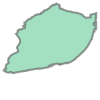

In [37]:
counties_dict, parishes_dict = load_shapefiles()
counties_dict['Lisboa']

Another source of data we'll use for analysis is a county by county purchasing power analysis. This data was compiled from the Portuguese Naational Statistics Institute. It provides values from 1 to 100 for every county, representing the percentile in purchasing power for each county. Source: https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_publicacoes&PUBLICACOESpub_boui=358634546&PUBLICACOESmodo=2

In [38]:
purchasing_power = pd.read_csv('/home/j/projects/wdl/1-stage/external-data/purchasing-power.csv', engine='python', sep=';')
purchasing_power.sample(2)

,County,Purchasing Power
7,Almada,98
244,Ribeira de Pena,21


In order to decode the DICOFRE codes in the CHURN_OD table, we'll use data from Portugal's public open access data service

In [39]:
parishes = pd.read_excel('https://dados.gov.pt/pt/datasets/r/ec6ef805-c278-4b4d-ba9b-3116264f68b4', engine="openpyxl")[['dicofre', 'freguesia']]
parishes.sample(2)

,dicofre,freguesia
1258,090501,Algodres
1525,101208,Gaeiras


# Building Intermediate Tables

## Building "Variation" table

We'll start by building what we call the **Variation** table. This table is obtained from the Churn_usersProfile.txt file. It contains, for each of the demographics (combinations of Origin County, Gender and Age), a value for the **variation in travellers between the first and second time periods** (in relative and absolute terms).  
If the variation values are negative for a row, that means there was churn for the specific demographic.  
Note that there are a number of demographics for which only the value in travellers for the first or second period was provided. These cases are left out from this 'Variation' table.

In [40]:
variation = build_variation_table(Churn_UsersProfile)
variation.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,GenderDescription,AgeClassDescription,Average_BusUsers_per_Day_first,Average_BusUsers_per_Day_second,Variation_abs,Variation_rel
0,R1 - AM Lisboa,Lisboa,Amadora,Female,15-24,294.194206,536.005174,241.810968,0.821943
1,R1 - AM Lisboa,Lisboa,Amadora,Female,25-34,1081.652817,408.068335,-673.584482,-0.622736


We now have, for each of the available demographics, relevant data where we can easily evaluate churn values

## Decoding Parish Code in Demand Table

In this notebook we'll obtain the **destination parish from the DICOFRE** codes. The output will be a demand table with the a column for destination parish, instead of DICOFRE code.

In [41]:
demand = decode_demand_dicofre(Churn_OD)
demand.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Parish_of_Public_Transportation,Demand_weight
0,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,Benfica,0.307323
1,R1 - AM Lisboa,Lisboa,Cascais,R1 - AM Lisboa,LISBOA,LISBOA,Benfica,0.068546


In this notebook we'll try to add to the **Demand** table an **estimation of the daily number of travellers**.  
This will be based on the Demand_weight fields, which is relative to the county. The value of travellers from each county is a weighted mean obtained by grouping data from the Users profile/Variation tables

# Variation Table Analysis

We believe this 'Variation' table is an extremely simple way to provide very powerful insights. For a county-level decision-maker, simply analysing the entries for their county will give a high-level idea of the change in the use of public transportation for each demographic. 

In [42]:
variation[variation.County_of_Origin == 'Lisboa'].sort_values('Variation_rel')

,Region_of_Origin,District_of_Origin,County_of_Origin,GenderDescription,AgeClassDescription,Average_BusUsers_per_Day_first,Average_BusUsers_per_Day_second,Variation_abs,Variation_rel
22,R1 - AM Lisboa,Lisboa,Lisboa,Female,15-24,2622.526139,669.444330,-1953.081809,-0.744733
29,R1 - AM Lisboa,Lisboa,Lisboa,Male,25-34,2919.594549,890.302313,-2029.292236,-0.695060
23,R1 - AM Lisboa,Lisboa,Lisboa,Female,25-34,1505.189142,735.866683,-769.322459,-0.511113
26,R1 - AM Lisboa,Lisboa,Lisboa,Female,55-64,2407.573978,1190.245303,-1217.328675,-0.505625
24,R1 - AM Lisboa,Lisboa,Lisboa,Female,35-44,1021.261465,507.994453,-513.267012,-0.502581
28,R1 - AM Lisboa,Lisboa,Lisboa,Male,15-24,3061.885495,1579.620589,-1482.264906,-0.484102
32,R1 - AM Lisboa,Lisboa,Lisboa,Male,55-64,1714.973185,1019.611822,-695.361363,-0.405465
25,R1 - AM Lisboa,Lisboa,Lisboa,Female,45-54,1217.651233,783.473925,-434.177308,-0.356570
33,R1 - AM Lisboa,Lisboa,Lisboa,Male,65+,4116.755355,3190.436995,-926.318360,-0.225012
30,R1 - AM Lisboa,Lisboa,Lisboa,Male,35-44,1289.676418,1073.288753,-216.387665,-0.167784


The 'Variation_rel' column provies especially useful information, since one can see very quickly e.g. that young females churned from publc transportation at an exceptionally high rate (74% reduction) between the two periods.

We can also group by the other features, and see the comparison between numbers of churn for Region, District and County of origin, as well as Gender and Age

In [43]:
# Groupby of Absolute and Relative Changes for some features
for col in ['Region_of_Origin','District_of_Origin', 'County_of_Origin', 'GenderDescription', 'AgeClassDescription']:
    first_period = variation.groupby(col)['Average_BusUsers_per_Day_first'].sum().to_frame().reset_index().sort_values(col, ascending=False)
    change = variation.groupby(col)['Variation_abs'].sum().to_frame().reset_index().sort_values(col, ascending=False)
    change['Variation_rel'] = change['Variation_abs'] / first_period['Average_BusUsers_per_Day_first']
    display(change.sort_values('Variation_rel'))

,Region_of_Origin,Variation_abs,Variation_rel
1,R2 - AM Porto,-113532.063372,-0.497695
0,R1 - AM Lisboa,-51762.788597,-0.320088


,District_of_Origin,Variation_abs,Variation_rel
2,Porto,-110634.275359,-0.498119
0,Aveiro,-2897.788013,-0.482044
1,Lisboa,-41671.105158,-0.345163
3,Setúbal,-10091.683439,-0.246226


,County_of_Origin,Variation_abs,Variation_rel
16,Oliveira de Azeméis,-2180.192075,-0.782438
10,Maia,-30536.665087,-0.630654
12,Moita,-1018.619872,-0.580433
9,Mafra,-1717.850609,-0.529534
25,Setúbal,-2447.718347,-0.515437
19,Porto,-24089.699828,-0.504295
4,Cascais,-6385.610578,-0.490303
6,Gondomar,-40206.615080,-0.479729
5,Espinho,-341.275992,-0.474737
29,Vila Franca de Xira,-4846.003738,-0.459554


,GenderDescription,Variation_abs,Variation_rel
1,Male,-82233.225835,-0.442764
0,Female,-83061.626134,-0.406960


,AgeClassDescription,Variation_abs,Variation_rel
1,25-34,-17220.940515,-0.525144
5,65+,-84524.568245,-0.440889
0,15-24,-16443.110233,-0.429465
3,45-54,-18278.466740,-0.399900
4,55-64,-19236.130004,-0.372249
2,35-44,-9591.636232,-0.323466


We can see that churn was significantly higher in the Oporto region, with expectable variations across counties, and that males churned more than females. We can also see that young adults (25-34) showed the highest rate of churn. We tend to focus on relative numbers of churn, since we believe these provide more significant information for local decision-makers.

# Visual Analysis

Since we're dealing with data related to transportation, plotting the information in maps is very useful to get a sense of the travels people are doing

We can see the origin counties are concentrated in the Greater Oporto and Lisbon areas. In this particular graph, red colours mean that there was churn in this particular county of origin lower number of travallers in the second period) while green means an incrase in passengers. These values are relative to the total number of passengers.  
Darker colours mean that there were more severe decreases in the number of passengers. We can see that the highest value of churn was for Oliveira de Azeméis, (southernmost couty in the Oporto region). The data plotted here is obtained by grouping change values by county (county_change dataframe shown below).

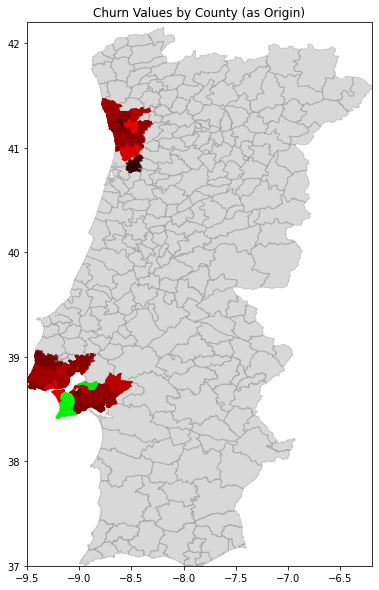

In [44]:
visualize_churn()

In [45]:
first_period = variation.groupby(['District_of_Origin','County_of_Origin'])['Average_BusUsers_per_Day_first'].sum().to_frame().reset_index().sort_values('County_of_Origin', ascending=False)
county_change = variation.groupby(['District_of_Origin','County_of_Origin'])['Variation_abs'].sum().to_frame().reset_index().sort_values('County_of_Origin', ascending=False)
county_change['Variation_rel'] = county_change['Variation_abs'] / first_period['Average_BusUsers_per_Day_first']
county_change.sort_values('Variation_rel').head(5)

,District_of_Origin,County_of_Origin,Variation_abs,Variation_rel
1,Aveiro,Oliveira de Azeméis,-2180.192075,-0.782438
13,Porto,Maia,-30536.665087,-0.630654
26,Setúbal,Moita,-1018.619872,-0.580433
7,Lisboa,Mafra,-1717.850609,-0.529534
31,Setúbal,Setúbal,-2447.718347,-0.515437


We believe that this simple dashboard provides very simple insights on where to tackle initiatives to fight churn, and the geographic notions presented by these maps make having a high-level view of the public transportation system very easy.

It's also interesting to note that, in Lisbon, the regions with lowest purchasing power (presented in darker shades of green) are the ones that showed least amounts of churn.

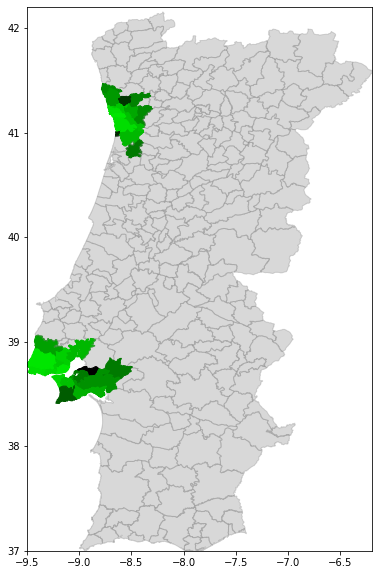

In [46]:
visualize_purchasing_power()

# Analyzing direction of Travel between counties

## Conclusions

### Scalability and Impact
The way our dahsboards and insights are calculated make them extensible by definition. If e.g. we decided to provide these dashboards to national-level decision-makers, the inclusion of data for more regions would make the insights provided even more powerful. Comparison between regions is also very easy.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀